In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [3]:
dji = pd.read_csv("DJI.csv")
dji = dji.iloc[:,1:]
tsla = pd.read_csv("TSLA.csv")
tsla = tsla.iloc[:,1:]
goog = pd.read_csv("GOOGL.csv")
goog = goog.iloc[:,1:]

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [4]:
minmax_scaler = MinMaxScaler()
dji = minmax_scaler.fit_transform(dji)
tsla = minmax_scaler.fit_transform(tsla)
goog = minmax_scaler.fit_transform(goog)

# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [5]:
def load_data(df, seq_len): 
    x_data = []
    valid = 0.0
    test = 0.15

    for i in range(seq_len, len(df)): 
        x_data.append(df[i-seq_len:i,:])
    
    x_data = np.array(x_data)
    valid_set_size = int(np.round(valid * x_data.shape[0]))
    test_set_size = int(np.round(test * x_data.shape[0]))
    train_set_size = x_data.shape[0] - (valid_set_size + test_set_size)

    x_train = x_data[:train_set_size,:-1]
    y_train = x_data[:train_set_size, 1, 1]
    y_train = y_train.reshape(-1,1)
    
    x_valid = x_data[train_set_size:train_set_size + valid_set_size, :-1]
    y_valid = x_data[train_set_size:train_set_size + valid_set_size, 1, 1]
    y_valid = y_valid.reshape(-1,1)
    
    x_test = x_data[train_set_size + valid_set_size:, :-1]
    y_test = x_data[train_set_size + valid_set_size:, 1, 1]
    y_test = y_test.reshape(-1,1)
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [46]:
seq_len = 15
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(dji, seq_len)
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_valid.shape =', x_valid.shape)
print('y_valid.shape =', y_valid.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (7328, 14, 6)
y_train.shape = (7328, 1)
x_valid.shape = (0, 14, 6)
y_valid.shape = (0, 1)
x_test.shape = (1293, 14, 6)
y_test.shape = (1293, 1)


# TesnorFlow Model

In [63]:
# Initialising the RNN
regressor = keras.Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(layers.LSTM(units = 200, return_sequences = True, input_shape = (x_train[0].shape)))
regressor.add(layers.Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(layers.LSTM(units = 200))
regressor.add(layers.Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
"""regressor.add(layers.LSTM(units = 64, return_sequences = True))
regressor.add(layers.Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(layers.LSTM(units = 64))
regressor.add(layers.Dropout(0.2))"""
# Adding the output layer
regressor.add(layers.Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [64]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = "min" ,patience=7)
history = regressor.fit(x_train, y_train, epochs=30, batch_size = 64, validation_split=0.1, callbacks=[callback])

Epoch 1/30
104/104 [==============================] - 3s 16ms/step - loss: 0.0018 - val_loss: 5.4940e-04
Epoch 2/30
104/104 [==============================] - 1s 11ms/step - loss: 2.5288e-04 - val_loss: 2.1632e-04
Epoch 3/30
104/104 [==============================] - 1s 12ms/step - loss: 2.1381e-04 - val_loss: 6.5076e-04
Epoch 4/30
104/104 [==============================] - 1s 11ms/step - loss: 2.4607e-04 - val_loss: 1.7987e-04
Epoch 5/30
104/104 [==============================] - 1s 11ms/step - loss: 2.2239e-04 - val_loss: 7.1916e-04
Epoch 6/30
104/104 [==============================] - 1s 12ms/step - loss: 2.3742e-04 - val_loss: 5.2212e-04
Epoch 7/30
104/104 [==============================] - 1s 11ms/step - loss: 1.9407e-04 - val_loss: 1.7449e-04
Epoch 8/30
104/104 [==============================] - 1s 11ms/step - loss: 1.7900e-04 - val_loss: 4.7657e-04
Epoch 9/30
104/104 [==============================] - 1s 11ms/step - loss: 1.9600e-04 - val_loss: 4.2800e-04
Epoch 10/30
104/104 [==

# Testing

In [65]:
regressor.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 14, 200)           165600    
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 200)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dropout_15 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 486,601
Trainable params: 486,601
Non-trainable params: 0
_________________________________________________________________


In [66]:
y_predict = regressor.predict(x_test)

In [67]:
regressor.evaluate(x_test, y_test)

41/41 [==============================] - 0s 4ms/step - loss: 0.0017


0.001727247261442244

In [68]:
y_predict.shape

(1293, 1)

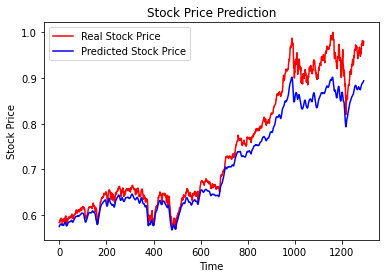

In [69]:
plt.plot(y_test, color = 'red', label = 'Real Stock Price')
plt.plot(y_predict, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [70]:
model_json = regressor.to_json()
with open("rnn_model_0.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
regressor.save_weights("rnn_model_0.h5")